# Question and Answer Chat Bots

## Loading the Data

We will be working with the Babi Data Set from Facebook Research.

Full Details: https://research.fb.com/downloads/babi/

- Jason Weston, Antoine Bordes, Sumit Chopra, Tomas Mikolov, Alexander M. Rush,
  "Towards AI-Complete Question Answering: A Set of Prerequisite Toy Tasks",
  http://arxiv.org/abs/1502.05698


In [1]:
import pickle
import numpy as np

In [2]:
with open('resources/train_qa.txt', "rb") as fp: # Unpickling
    train_data = pickle.load(fp)

In [3]:
with open('resources/test_qa.txt', "rb") as fp: # Unpickling
    test_data = pickle.load(fp)

## Exploring the Format of the Data

In [4]:
# The type of the training and test data is a list
print(f'The type of train_data : {type(train_data)}')

The type of train_data : <class 'list'>


In [5]:
# Length of the train and test data
print(f'The length of train_data : {len(train_data)}')
print(f'The length of test_data : {len(test_data)}')

The length of train_data : 10000
The length of test_data : 1000


In [12]:
# Explore the first element of the list
train_data[0]

(['Mary',
  'moved',
  'to',
  'the',
  'bathroom',
  '.',
  'Sandra',
  'journeyed',
  'to',
  'the',
  'bedroom',
  '.'],
 ['Is', 'Sandra', 'in', 'the', 'hallway', '?'],
 'no')

In [13]:
# Explore the story in the first element
train_data[0][0]

['Mary',
 'moved',
 'to',
 'the',
 'bathroom',
 '.',
 'Sandra',
 'journeyed',
 'to',
 'the',
 'bedroom',
 '.']

In [14]:
# Explore the Question in the first element
train_data[0][1]

['Is', 'Sandra', 'in', 'the', 'hallway', '?']

In [15]:
# Explore the response in the first element
train_data[0][2]

'no'

-----

## Setting up Vocabulary of All Words

In [17]:
# Now we will use a set in python which is an unordered collection of unique elements
vocab = set()

all_data = train_data + test_data

In [18]:
for story, question, answer in all_data:
    vocab = vocab.union(set(story))
    vocab = vocab.union(set(question))

In [19]:
vocab.add('no')
vocab.add('yes')

In [20]:
# To see the unique words
vocab

{'.',
 '?',
 'Daniel',
 'Is',
 'John',
 'Mary',
 'Sandra',
 'apple',
 'back',
 'bathroom',
 'bedroom',
 'discarded',
 'down',
 'dropped',
 'football',
 'garden',
 'got',
 'grabbed',
 'hallway',
 'in',
 'journeyed',
 'kitchen',
 'left',
 'milk',
 'moved',
 'no',
 'office',
 'picked',
 'put',
 'the',
 'there',
 'to',
 'took',
 'travelled',
 'up',
 'went',
 'yes'}

In [21]:
# To get the length of the vocab
vocab_len = len(vocab) + 1 # we add an extra space to hold a 0 for Keras's pad_sequences

In [29]:
# To get the max story length - as the first element [0] is the story and second element is [1] is question
max_story_len = max([len(data[0]) for data in all_data])
max_story_len

156

In [31]:
max_question_len = max([len(data[1]) for data in all_data])
max_question_len

6

## Vectorizing the Data

In [32]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [33]:
# integer encode sequences of words
tokenizer = tf.keras.preprocessing.text.Tokenizer(filters=[])
tokenizer.fit_on_texts(vocab)

In [34]:
tokenizer.word_index

{'is': 1,
 'up': 2,
 'moved': 3,
 'hallway': 4,
 'back': 5,
 'dropped': 6,
 'milk': 7,
 'there': 8,
 '.': 9,
 'garden': 10,
 'apple': 11,
 'to': 12,
 'put': 13,
 '?': 14,
 'in': 15,
 'no': 16,
 'got': 17,
 'took': 18,
 'mary': 19,
 'picked': 20,
 'football': 21,
 'office': 22,
 'bedroom': 23,
 'yes': 24,
 'john': 25,
 'journeyed': 26,
 'travelled': 27,
 'kitchen': 28,
 'down': 29,
 'sandra': 30,
 'the': 31,
 'daniel': 32,
 'grabbed': 33,
 'bathroom': 34,
 'left': 35,
 'discarded': 36,
 'went': 37}

In [35]:
train_story_text = []
train_question_text = []
train_answers = []

for story,question,answer in train_data:
    train_story_text.append(story)
    train_question_text.append(question)

In [36]:
train_story_seq = tokenizer.texts_to_sequences(train_story_text)

In [37]:
len(train_story_text)

10000

In [38]:
len(train_story_seq)

10000

### Functionalize Vectorization

In [43]:
def vectorize_stories(data, word_index=tokenizer.word_index, max_story_len=max_story_len,max_question_len=max_question_len):
    '''
    INPUT: 
    
    data: consisting of Stories,Queries,and Answers
    word_index: word index dictionary from tokenizer
    max_story_len: the length of the longest story (used for pad_sequences function)
    max_question_len: length of the longest question (used for pad_sequences function)


    OUTPUT:
    
    Vectorizes the stories,questions, and answers into padded sequences. We first loop for every story, query , and
    answer in the data. Then we convert the raw words to an word index value. Then we append each set to their appropriate
    output list. Then once we have converted the words to numbers, we pad the sequences so they are all of equal length.
    
    Returns this in the form of a tuple (X,Xq,Y) (padded based on max lengths)
    '''
    
    
    # X = STORIES
    X = []
    # Xq = QUERY/QUESTION
    Xq = []
    # Y = CORRECT ANSWER
    Y = []
    
    
    for story, query, answer in data:
        
        # Grab the word index for every word in story
        x = [word_index[word.lower()] for word in story]
        # Grab the word index for every word in query
        xq = [word_index[word.lower()] for word in query]
        
        # Grab the Answers (either Yes/No so we don't need to use list comprehension here)
        # Index 0 is reserved so we're going to use + 1
        y = np.zeros(len(word_index) + 1)
        
        # Now that y is all zeros and we know its just Yes/No , we can use numpy logic to create this assignment
        #
        y[word_index[answer]] = 1
        
        # Append each set of story,query, and answer to their respective holding lists
        X.append(x)
        Xq.append(xq)
        Y.append(y)
        
    # Finally, pad the sequences based on their max length so the RNN can be trained on uniformly long sequences.
        
    # RETURN TUPLE FOR UNPACKING
    return (tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=max_story_len),
            tf.keras.preprocessing.sequence.pad_sequences(Xq, maxlen=max_question_len), np.array(Y))

In [44]:
inputs_train, queries_train, answers_train = vectorize_stories(train_data)

In [45]:
inputs_test, queries_test, answers_test = vectorize_stories(test_data)

In [46]:
inputs_test

array([[ 0,  0,  0, ..., 31, 23,  9],
       [ 0,  0,  0, ..., 31, 10,  9],
       [ 0,  0,  0, ..., 31, 10,  9],
       ...,
       [ 0,  0,  0, ..., 31, 11,  9],
       [ 0,  0,  0, ..., 31, 10,  9],
       [ 0,  0,  0, ..., 11,  8,  9]])

In [47]:
queries_test

array([[ 1, 25, 15, 31, 28, 14],
       [ 1, 25, 15, 31, 28, 14],
       [ 1, 25, 15, 31, 10, 14],
       ...,
       [ 1, 19, 15, 31, 23, 14],
       [ 1, 30, 15, 31, 10, 14],
       [ 1, 19, 15, 31, 10, 14]])

In [48]:
answers_test

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [49]:
sum(answers_test)

array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0., 503.,   0.,   0.,   0.,   0.,   0.,
         0.,   0., 497.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.])

In [50]:
tokenizer.word_index['yes']

24

In [51]:
tokenizer.word_index['no']

16

## Creating the Model

### Placeholders for Inputs

Recall we technically have two inputs, stories and questions. So we need to use placeholders. `Input()` is used to instantiate a Keras tensor.


In [53]:
input_sequence = tf.keras.layers.Input((max_story_len,))
question = tf.keras.layers.Input((max_question_len,))

### Building the Networks

To understand why we chose this setup, make sure to read the paper we are using:

* Sainbayar Sukhbaatar, Arthur Szlam, Jason Weston, Rob Fergus,
  "End-To-End Memory Networks",
  http://arxiv.org/abs/1503.08895

## Encoders

### Input Encoder m

In [56]:
# Reserve 0 for pad_sequences
vocab_size = len(vocab) + 1

In [57]:
# Input gets embedded to a sequence of vectors
input_encoder_m = tf.keras.models.Sequential()
input_encoder_m.add(tf.keras.layers.Embedding(input_dim=vocab_size,output_dim=64))
input_encoder_m.add(tf.keras.layers.Dropout(0.3))

# This encoder will output:
# (samples, story_maxlen, embedding_dim)

### Input Encoder c

In [59]:
# embed the input into a sequence of vectors of size query_maxlen
input_encoder_c = tf.keras.models.Sequential()
input_encoder_c.add(tf.keras.layers.Embedding(input_dim=vocab_size,output_dim=max_question_len))
input_encoder_c.add(tf.keras.layers.Dropout(0.3))
# output: (samples, story_maxlen, query_maxlen)

### Question Encoder

In [60]:
# embed the question into a sequence of vectors
question_encoder = tf.keras.models.Sequential()
question_encoder.add(tf.keras.layers.Embedding(input_dim=vocab_size,
                               output_dim=64,
                               input_length=max_question_len))
question_encoder.add(tf.keras.layers.Dropout(0.3))
# output: (samples, query_maxlen, embedding_dim)

### Encode the Sequences

In [61]:
# encode input sequence and questions (which are indices)
# to sequences of dense vectors
input_encoded_m = input_encoder_m(input_sequence)
input_encoded_c = input_encoder_c(input_sequence)
question_encoded = question_encoder(question)

##### Use dot product to compute the match between first input vector seq and the query

In [64]:
# shape: `(samples, story_maxlen, query_maxlen)`
match = tf.keras.layers.dot([input_encoded_m, question_encoded], axes=(2, 2))
match = tf.keras.layers.Activation('softmax')(match)

#### Add this match matrix with the second input vector sequence

In [66]:
# add the match matrix with the second input vector sequence
response = tf.keras.layers.add([match, input_encoded_c])  # (samples, story_maxlen, query_maxlen)
response = tf.keras.layers.Permute((2, 1))(response)  # (samples, query_maxlen, story_maxlen)

#### Concatenate

In [69]:
# concatenate the match matrix with the question vector sequence
answer = tf.keras.layers.concatenate([response, question_encoded])

In [70]:
answer

<tf.Tensor 'concatenate_1/Identity:0' shape=(None, 6, 220) dtype=float32>

In [71]:
# Reduce with RNN (LSTM)
answer = tf.keras.layers.LSTM(32)(answer)  # (samples, 32)

In [72]:
# Regularization with Dropout
answer = tf.keras.layers.Dropout(0.5)(answer)
answer = tf.keras.layers.Dense(vocab_size)(answer)  # (samples, vocab_size)

In [73]:
# we output a probability distribution over the vocabulary
answer = tf.keras.layers.Activation('softmax')(answer)

# build the final model
model = tf.keras.models.Model([input_sequence, question], answer)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',
              metrics=['accuracy'])

In [74]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 156)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 6)]          0                                            
__________________________________________________________________________________________________
sequential_2 (Sequential)       multiple             2432        input_1[0][0]                    
__________________________________________________________________________________________________
sequential_4 (Sequential)       (None, 6, 64)        2432        input_2[0][0]                    
______________________________________________________________________________________________

In [75]:
# train
history = model.fit([inputs_train, queries_train], answers_train,batch_size=32, epochs=120, 
                    validation_data=([inputs_test, queries_test], answers_test))

Train on 10000 samples, validate on 1000 samples
Epoch 1/120
10000/10000 [==============================] - 13s 1ms/sample - loss: 0.9059 - accuracy: 0.4911 - val_loss: 0.6953 - val_accuracy: 0.5030
Epoch 2/120
10000/10000 [==============================] - 2s 199us/sample - loss: 0.7029 - accuracy: 0.5115 - val_loss: 0.6993 - val_accuracy: 0.5030
Epoch 3/120
10000/10000 [==============================] - 2s 199us/sample - loss: 0.6974 - accuracy: 0.4952 - val_loss: 0.6939 - val_accuracy: 0.4970
Epoch 4/120
10000/10000 [==============================] - 2s 202us/sample - loss: 0.6955 - accuracy: 0.4930 - val_loss: 0.6936 - val_accuracy: 0.5030
Epoch 5/120
10000/10000 [==============================] - 2s 203us/sample - loss: 0.6949 - accuracy: 0.4923 - val_loss: 0.6939 - val_accuracy: 0.5030
Epoch 6/120
10000/10000 [==============================] - 2s 201us/sample - loss: 0.6943 - accuracy: 0.5081 - val_loss: 0.6934 - val_accuracy: 0.4970
Epoch 7/120
10000/10000 [=====================

10000/10000 [==============================] - 2s 203us/sample - loss: 0.2924 - accuracy: 0.8718 - val_loss: 0.3569 - val_accuracy: 0.8290
Epoch 55/120
10000/10000 [==============================] - 2s 201us/sample - loss: 0.2926 - accuracy: 0.8738 - val_loss: 0.3759 - val_accuracy: 0.8300
Epoch 56/120
10000/10000 [==============================] - 2s 201us/sample - loss: 0.2868 - accuracy: 0.8756 - val_loss: 0.4116 - val_accuracy: 0.8210
Epoch 57/120
10000/10000 [==============================] - 2s 202us/sample - loss: 0.2917 - accuracy: 0.8717 - val_loss: 0.3785 - val_accuracy: 0.8270
Epoch 58/120
10000/10000 [==============================] - 2s 201us/sample - loss: 0.2894 - accuracy: 0.8745 - val_loss: 0.3653 - val_accuracy: 0.8350
Epoch 59/120
10000/10000 [==============================] - 2s 200us/sample - loss: 0.2889 - accuracy: 0.8749 - val_loss: 0.3838 - val_accuracy: 0.8300
Epoch 60/120
10000/10000 [==============================] - 2s 200us/sample - loss: 0.2868 - accuracy

Epoch 108/120
10000/10000 [==============================] - 2s 203us/sample - loss: 0.2331 - accuracy: 0.8999 - val_loss: 0.4997 - val_accuracy: 0.8150
Epoch 109/120
10000/10000 [==============================] - 2s 199us/sample - loss: 0.2338 - accuracy: 0.9007 - val_loss: 0.4864 - val_accuracy: 0.8260
Epoch 110/120
10000/10000 [==============================] - 2s 201us/sample - loss: 0.2280 - accuracy: 0.9016 - val_loss: 0.4526 - val_accuracy: 0.8240
Epoch 111/120
10000/10000 [==============================] - 2s 200us/sample - loss: 0.2292 - accuracy: 0.9037 - val_loss: 0.5063 - val_accuracy: 0.8240
Epoch 112/120
10000/10000 [==============================] - 2s 201us/sample - loss: 0.2340 - accuracy: 0.8959 - val_loss: 0.4850 - val_accuracy: 0.8260
Epoch 113/120
10000/10000 [==============================] - 2s 200us/sample - loss: 0.2300 - accuracy: 0.9005 - val_loss: 0.5007 - val_accuracy: 0.8200
Epoch 114/120
10000/10000 [==============================] - 2s 201us/sample - los

### Saving the Model

In [76]:
filename = 'chatbot_120_epochs.h5'
model.save(filename)

## Evaluating the Model

### Plotting Out Training History

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


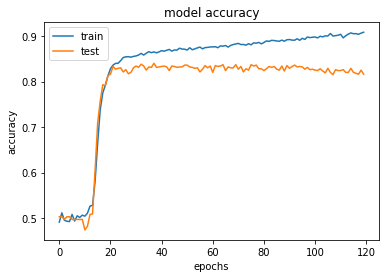

In [93]:
import matplotlib.pyplot as plt
%matplotlib inline
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Evaluating on Given Test Set

In [79]:
model.load_weights(filename)
pred_results = model.predict(([inputs_test, queries_test]))

In [80]:
test_data[0][0]

['Mary',
 'got',
 'the',
 'milk',
 'there',
 '.',
 'John',
 'moved',
 'to',
 'the',
 'bedroom',
 '.']

In [81]:
story =' '.join(word for word in test_data[0][0])
print(story)

Mary got the milk there . John moved to the bedroom .


In [82]:
query = ' '.join(word for word in test_data[0][1])
print(query)

Is John in the kitchen ?


In [83]:
print("True Test Answer from Data is:",test_data[0][2])

True Test Answer from Data is: no


In [84]:
#Generate prediction from model
val_max = np.argmax(pred_results[0])

for key, val in tokenizer.word_index.items():
    if val == val_max:
        k = key

print("Predicted answer is: ", k)
print("Probability of certainty was: ", pred_results[0][val_max])

Predicted answer is:  no
Probability of certainty was:  0.99995375


## Writing Your Own Stories and Questions

Remember you can only use words from the existing vocab

In [85]:
vocab

{'.',
 '?',
 'Daniel',
 'Is',
 'John',
 'Mary',
 'Sandra',
 'apple',
 'back',
 'bathroom',
 'bedroom',
 'discarded',
 'down',
 'dropped',
 'football',
 'garden',
 'got',
 'grabbed',
 'hallway',
 'in',
 'journeyed',
 'kitchen',
 'left',
 'milk',
 'moved',
 'no',
 'office',
 'picked',
 'put',
 'the',
 'there',
 'to',
 'took',
 'travelled',
 'up',
 'went',
 'yes'}

In [86]:
# Note the whitespace of the periods
my_story = "John left the kitchen . Sandra dropped the football in the garden ."
my_story.split()

['John',
 'left',
 'the',
 'kitchen',
 '.',
 'Sandra',
 'dropped',
 'the',
 'football',
 'in',
 'the',
 'garden',
 '.']

In [87]:
my_question = "Is the football in the garden ?"

In [88]:
my_question.split()

['Is', 'the', 'football', 'in', 'the', 'garden', '?']

In [89]:
mydata = [(my_story.split(),my_question.split(),'yes')]

In [90]:
my_story,my_ques,my_ans = vectorize_stories(mydata)

In [91]:
pred_results = model.predict(([ my_story, my_ques]))

In [92]:
#Generate prediction from model
val_max = np.argmax(pred_results[0])

for key, val in tokenizer.word_index.items():
    if val == val_max:
        k = key

print("Predicted answer is: ", k)
print("Probability of certainty was: ", pred_results[0][val_max])

Predicted answer is:  yes
Probability of certainty was:  0.68924487
